In [8]:
using QuantumOptics
using IonSim
import PyPlot
const plt = PyPlot

┌ Info: Precompiling IonSim [511e77fe-ab93-41f7-8f07-8f89809c6435]
└ @ Base loading.jl:1273


PyPlot

In [9]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

In [10]:
# Construct the system
# here we'll use global lasers on the axial stretch mode for the σzX interaction, this will effect both ions
# but the effect will be perfectly anti-correlated, so the result should be the same (modulo some scale factors)
# as driving the interaction on only a single ion
C = ca40(selected_level_structure=["S-1/2", "D-1/2"])
L1 = laser()
L2 = laser()
L3 = laser()
L4 = laser()
chain = linearchain(ions=[C, C], com_frequencies=(x=3e6,y=3e6,z=1e6), selected_modes=(x=[], y=[], z=[1, 2]))
T = trap(configuration=chain, B=6e-4, Bhat=(x̂ + ẑ)/√2, lasers=[L1, L2, L3, L4]);

┌ Warning: some ions point to the same thing. Making copies.
└ @ IonSim /Users/joe/Desktop/IonSim/IonSim.jl/src/ion_configurations.jl:162


In [11]:
# Set the MS laser parameters
com_mode = T.configuration.vibrational_modes.z[1]
stretch_mode = T.configuration.vibrational_modes.z[2]
com_mode.N = 3
stretch_mode.N = 5

Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
ϵ = 40e3

L1.Δ = Δf + com_mode.ν + ϵ 
L1.k = ẑ
L1.ϵ = x̂

L2.Δ = Δf - com_mode.ν - ϵ
L2.k = ẑ
L2.ϵ = x̂

η = abs(get_η(com_mode, L1, C))
Ω = √(1e3 * ϵ) / η  # This will give a 1kHz MS strength, since coupling goes like (ηΩ)^2/ϵ

Efield_from_rabi_frequency!(Ω, T, 1, 1, ("S-1/2", "D-1/2"))
Efield_from_rabi_frequency!(Ω, T, 2, 1, ("S-1/2", "D-1/2"));

In [12]:
# Set σzX laser parameters
Δf = transition_frequency(T, 2, ("S-1/2", "D-1/2"))
νeff = √5.25 * 0.71e3 

L3.Δ = Δf + stretch_mode.ν / 2 + νeff  # We set the effective vibrational frequency by detuning the 2-phonon transition off resonance
L3.k = ẑ
L3.ϵ = x̂

L4.Δ = Δf - stretch_mode.ν / 2 
L4.k = ẑ
L4.ϵ = x̂

η = abs(get_η(stretch_mode, L3, C))
Ω = √((0.75e3 * stretch_mode.ν) / η)  # Set κ = 2 kHz, since κ = ηΩ^2/ν

Efield_from_rabi_frequency!(Ω, T, 3, 2, ("S-1/2", "D-1/2"))
Efield_from_rabi_frequency!(Ω, T, 4, 2, ("S-1/2", "D-1/2"));

In [13]:
# set detuning with gradient
set_gradient!(T, (1, 2), ("S-1/2", "D-1/2"), √5.25 * 1e3); 

In [14]:
h = hamiltonian(T, lamb_dicke_order=1, rwa_cutoff=1e6);

In [15]:
ψi = ion_state(T, "D-1/2", "S-1/2") ⊗ fockstate(com_mode.basis, 0) ⊗ fockstate(stretch_mode.basis, 0)
@time tout, sol = timeevolution.schroedinger_dynamic(0:10:6000, ψi, h);

 29.352711 seconds (79.09 M allocations: 2.998 GiB, 3.57% gc time)


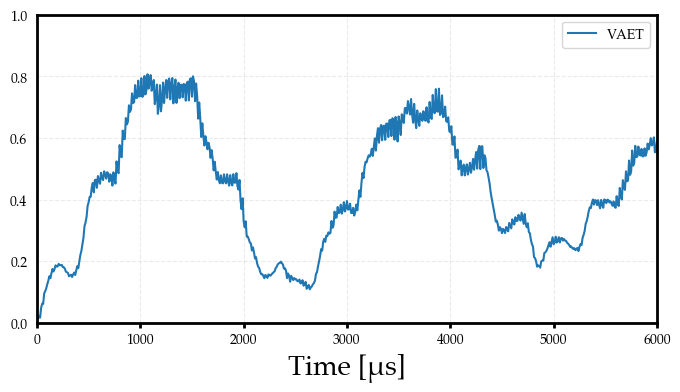

In [16]:
SD_vaet = expect(ion_projector(T, "S-1/2", "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], SD_vaet[1:step:end], label="VAET")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");

Longitudinal white nose on a single ion -- Lindblad Master Equation

In [17]:
# ρi = ion_state(T, "D-1/2", "S-1/2") ⊗ fockstate(com_mode.basis, 0) ⊗ fockstate(stretch_mode.basis, 0)
ion2 = T.configuration.ions[2]
noise_op = embed(get_basis(T), [2], [-ion2["S-1/2"] ⊗ ion2["S-1/2"]' + ion2["D-1/2"] ⊗ ion2["D-1/2"]'])
γ = 1/4e3
L(t, ρ) = (h(t, ρ), [noise_op], [noise_op], [γ])
@time tout, sol = timeevolution.master_dynamic(0:10:6000, ψi, L);

319.215522 seconds (74.47 M allocations: 2.689 GiB, 0.30% gc time)


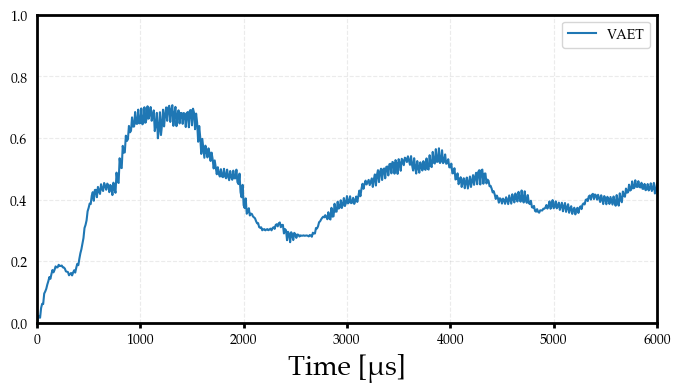

In [18]:
SD_vaet = expect(ion_projector(T, "S-1/2", "D-1/2"), sol)
step = 1
plt.plot(tout[1:step:end], SD_vaet[1:step:end], label="VAET")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");

Longitudinal white nose on a single ion -- quantum jump formalism

In [599]:
sols = zero(tout)
Ntraj = 10
for _ in 1:Ntraj
    tout, sol = timeevolution.mcwf_dynamic(0:10.:6000, ψi, L)
    sols .+= expect(ion_projector(T, "S-1/2", "D-1/2"), sol) ./ Ntraj 
end

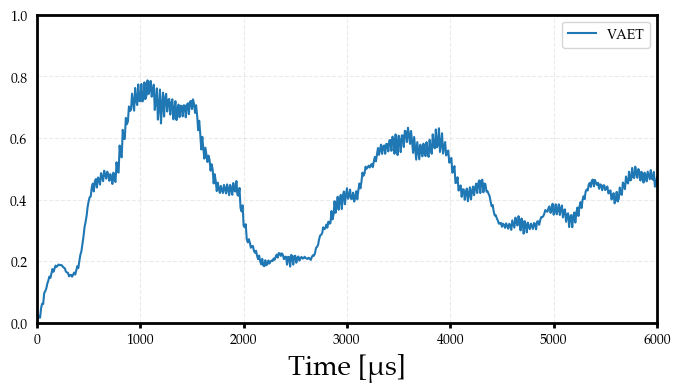

In [600]:
step = 1
plt.plot(tout[1:step:end], sols, label="VAET")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time [μs]");

in this case, the total run time necessary for reasonable approximation is comparable to the master equation.

Longitudinal noise on a single ion -- Bloch-Redfield 

In [607]:
ht = h(1.0, 0);

In [613]:
using Arpack: eigs

In [619]:
using BenchmarkTools

In [638]:
?eigs

search: eigenstates eigvecs eigvals eigvals! leading_ones leading_zeros



```
eigs(A; nev=6, ncv=max(20,2*nev+1), which=:LM, tol=0.0, maxiter=300, sigma=nothing, ritzvec=true, v0=zeros((0,))) -> (d,[v,],nconv,niter,nmult,resid)
```

Computes eigenvalues `d` of `A` using implicitly restarted Lanczos or Arnoldi iterations for real symmetric or general nonsymmetric matrices respectively. See [the manual](@ref lib-itereigen) for more information.

`eigs` returns the `nev` requested eigenvalues in `d`, the corresponding Ritz vectors `v` (only if `ritzvec=true`), the number of converged eigenvalues `nconv`, the number of iterations `niter` and the number of matrix vector multiplications `nmult`, as well as the final residual vector `resid`.

# Examples

```jldoctest
julia> using Arpack

julia> A = Diagonal(1:4);

julia> λ, ϕ = eigs(A, nev = 2);

julia> λ
2-element Array{Float64,1}:
 4.0
 3.0
```

---

```
eigs(A, B; nev=6, ncv=max(20,2*nev+1), which=:LM, tol=0.0, maxiter=300, sigma=nothing, ritzvec=true, v0=zeros((0,))) -> (d,[v,],nconv,niter,nmult,resid)
```

Computes generalized eigenvalues `d` of `A` and `B` using implicitly restarted Lanczos or Arnoldi iterations for real symmetric or general nonsymmetric matrices respectively. See [the manual](@ref lib-itereigen) for more information.


In [637]:
eigs(ht.data)[2][

0.22833388432310014 + 0.44447299126272904im

In [628]:
ht_fixed = zero(ht.data)
@benchmark ht_fixed .= eigs(ht.data)[2]

DimensionMismatch: DimensionMismatch("array could not be broadcast to match destination")

In [623]:
@benchmark h(1.0, 0)

BenchmarkTools.Trial: 
  memory estimate:  2.38 KiB
  allocs estimate:  76
  --------------
  minimum time:     24.397 μs (0.00% GC)
  median time:      42.394 μs (0.00% GC)
  mean time:        41.015 μs (0.00% GC)
  maximum time:     2.619 ms (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [646]:
val_fixed = zeros(Float64, 60)
vec_fixed = zero(ht.data)
@benchmark val_fixed, vec_fixed .= eigen(dense(h(1.0, 0)).data)...

DimensionMismatch: DimensionMismatch("array could not be broadcast to match destination")

In [674]:
htest = dense(h(1.0, 0)).data
eigen!(htest);

In [680]:
?eigen

search: eigen eigen! Eigen eigenstates eigenenergies GeneralizedEigen eigvecs



```
eigen(A; permute::Bool=true, scale::Bool=true, sortby) -> Eigen
```

Computes the eigenvalue decomposition of `A`, returning an `Eigen` factorization object `F` which contains the eigenvalues in `F.values` and the eigenvectors in the columns of the matrix `F.vectors`. (The `k`th eigenvector can be obtained from the slice `F.vectors[:, k]`.)

Iterating the decomposition produces the components `F.values` and `F.vectors`.

The following functions are available for `Eigen` objects: [`inv`](@ref), [`det`](@ref), and [`isposdef`](@ref).

For general nonsymmetric matrices it is possible to specify how the matrix is balanced before the eigenvector calculation. The option `permute=true` permutes the matrix to become closer to upper triangular, and `scale=true` scales the matrix by its diagonal elements to make rows and columns more equal in norm. The default is `true` for both options.

By default, the eigenvalues and vectors are sorted lexicographically by `(real(λ),imag(λ))`. A different comparison function `by(λ)` can be passed to `sortby`, or you can pass `sortby=nothing` to leave the eigenvalues in an arbitrary order.   Some special matrix types (e.g. `Diagonal` or `SymTridiagonal`) may implement their own sorting convention and not accept a `sortby` keyword.

# Examples

```jldoctest
julia> F = eigen([1.0 0.0 0.0; 0.0 3.0 0.0; 0.0 0.0 18.0])
Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
eigenvalues:
3-element Array{Float64,1}:
  1.0
  3.0
 18.0
eigenvectors:
3×3 Array{Float64,2}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

julia> F.values
3-element Array{Float64,1}:
  1.0
  3.0
 18.0

julia> F.vectors
3×3 Array{Float64,2}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

julia> vals, vecs = F; # destructuring via iteration

julia> vals == F.values && vecs == F.vectors
true
```

---

```
eigen(A, B) -> GeneralizedEigen
```

Computes the generalized eigenvalue decomposition of `A` and `B`, returning a `GeneralizedEigen` factorization object `F` which contains the generalized eigenvalues in `F.values` and the generalized eigenvectors in the columns of the matrix `F.vectors`. (The `k`th generalized eigenvector can be obtained from the slice `F.vectors[:, k]`.)

Iterating the decomposition produces the components `F.values` and `F.vectors`.

Any keyword arguments passed to `eigen` are passed through to the lower-level [`eigen!`](@ref) function.

# Examples

```jldoctest
julia> A = [1 0; 0 -1]
2×2 Array{Int64,2}:
 1   0
 0  -1

julia> B = [0 1; 1 0]
2×2 Array{Int64,2}:
 0  1
 1  0

julia> F = eigen(A, B);

julia> F.values
2-element Array{Complex{Float64},1}:
 0.0 - 1.0im
 0.0 + 1.0im

julia> F.vectors
2×2 Array{Complex{Float64},2}:
  0.0+1.0im   0.0-1.0im
 -1.0+0.0im  -1.0-0.0im

julia> vals, vecs = F; # destructuring via iteration

julia> vals == F.values && vecs == F.vectors
true
```

---

```
eigen(A::Union{SymTridiagonal, Hermitian, Symmetric}, irange::UnitRange) -> Eigen
```

Computes the eigenvalue decomposition of `A`, returning an `Eigen` factorization object `F` which contains the eigenvalues in `F.values` and the eigenvectors in the columns of the matrix `F.vectors`. (The `k`th eigenvector can be obtained from the slice `F.vectors[:, k]`.)

Iterating the decomposition produces the components `F.values` and `F.vectors`.

The following functions are available for `Eigen` objects: [`inv`](@ref), [`det`](@ref), and [`isposdef`](@ref).

The `UnitRange` `irange` specifies indices of the sorted eigenvalues to search for.

!!! note
    If `irange` is not `1:n`, where `n` is the dimension of `A`, then the returned factorization will be a *truncated* factorization.


---

```
eigen(A::Union{SymTridiagonal, Hermitian, Symmetric}, vl::Real, vu::Real) -> Eigen
```

Computes the eigenvalue decomposition of `A`, returning an `Eigen` factorization object `F` which contains the eigenvalues in `F.values` and the eigenvectors in the columns of the matrix `F.vectors`. (The `k`th eigenvector can be obtained from the slice `F.vectors[:, k]`.)

Iterating the decomposition produces the components `F.values` and `F.vectors`.

The following functions are available for `Eigen` objects: [`inv`](@ref), [`det`](@ref), and [`isposdef`](@ref).

`vl` is the lower bound of the window of eigenvalues to search for, and `vu` is the upper bound.

!!! note
    If [`vl`, `vu`] does not contain all eigenvalues of `A`, then the returned factorization will be a *truncated* factorization.



BenchmarkTools.Trial: 
  memory estimate:  2.38 KiB
  allocs estimate:  76
  --------------
  minimum time:     24.861 μs (0.00% GC)
  median time:      25.235 μs (0.00% GC)
  mean time:        25.791 μs (0.00% GC)
  maximum time:     133.518 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1